In [3]:
!python3.11 -m pip install pandas


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!python3.11 -m pip install timm opencv-python torch urllib3 matplotlib

  Using cached timm-1.0.14-py3-none-any.whl.metadata (50 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached matplotlib-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached torchvision-0.21.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.28.1-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.5.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata (28 kB)
Using cached timm-1.0.14-py3-none-any.whl (2.4 MB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)

In [5]:
!python3.11 -m pip install numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x304948650>)

In [7]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/adamrolander/.cache/torch/hub/intel-isl_MiDaS_master
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [9]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/adamrolander/.cache/torch/hub/intel-isl_MiDaS_master


In [19]:
img = cv2.imread("SS1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [42]:
img = cv2.imread("Documents/pinecone.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [20]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

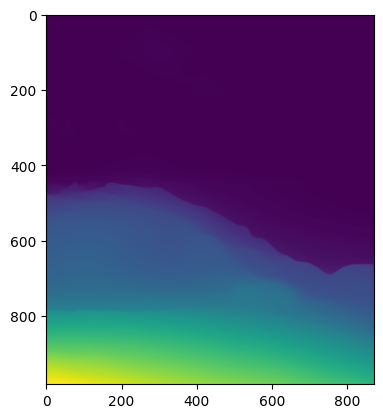

In [23]:
plt.imshow(output)
# cv2.imwrite(f"SS1_depth.png", output)

In [105]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output2 = prediction.cpu().numpy()

In [110]:
import cv2
import numpy as np
cv2.imwrite("output/depth_map.png", (output2 * 65535).astype(np.uint16))

True

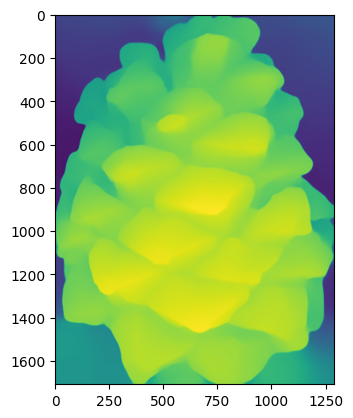

In [48]:
plt.imshow(output2)

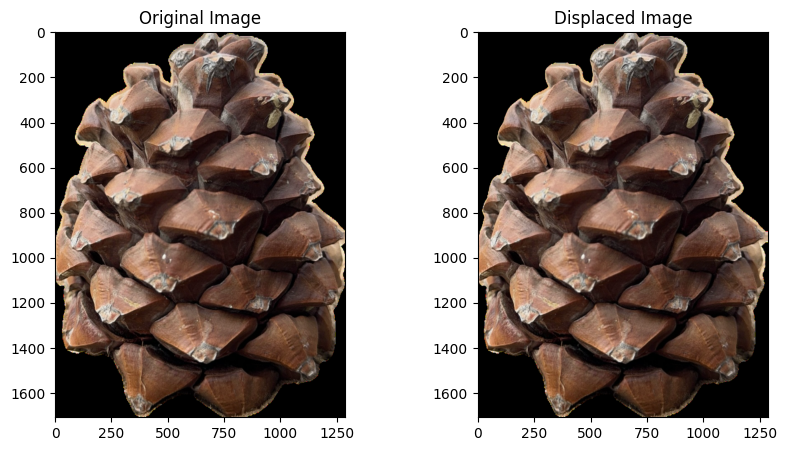

In [57]:
import numpy as np

depth_map = output2
depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

displacement_scale = 20 # Adjust and see

h, w = depth_map.shape
displacement_map = np.zeros((h, w, 2), dtype = np.float32)

for y in range(h):
    for x in range(w):
        shift = (displacement_scale * depth_map[y, x]) # Shifting by closeness (closer = farther shift)
        new_x = min(w - 1, max(0, x + shift))
        displacement_map[y, x] = [new_x - x, 0] 

# Remapping to original image
image = cv2.imread("Downloads/Subject.png")
image = cv2.resize(image, (w, h)) 

map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
map_x = (map_x + displacement_map[..., 0]).astype(np.float32)
map_y = (map_y + displacement_map[..., 1]).astype(np.float32)
warped_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)

# Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title("Displaced Image")

plt.show()

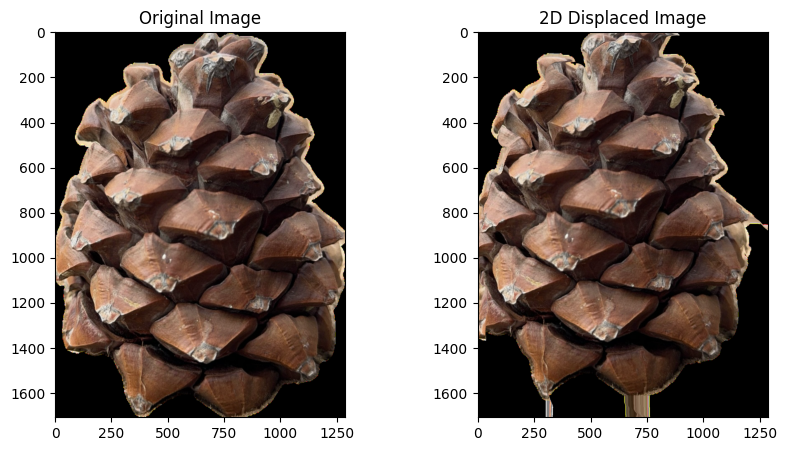

In [70]:
depth_map = output2
depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

displacement_x = 100 
displacement_y = 100

# Apply square root scaling
scaled_depth = np.sqrt(depth_map)  # Sqrt scaling

# Create displacement map
h, w = depth_map.shape
displacement_map = np.zeros((h, w, 2), dtype=np.float32)

for y in range(h):
    for x in range(w):
        shift_x = int(displacement_x * scaled_depth[y, x])  # Horizontal shift
        shift_y = int(displacement_y * scaled_depth[y, x])  # Vertical shift
        new_x = min(w - 1, max(0, x + shift_x))  
        new_y = min(h - 1, max(0, y + shift_y))
        displacement_map[y, x] = [new_x - x, new_y - y]

# Apply displacement
image = cv2.imread("Downloads/Subject.png")  # Load original image
image = cv2.resize(image, (w, h))  # Match depth map size
map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
map_x = (map_x + displacement_map[..., 0]).astype(np.float32)
map_y = (map_y + displacement_map[..., 1]).astype(np.float32)
warped_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

mask = (map_x >= 0) & (map_x < w) & (map_y >= 0) & (map_y < h)
warped_image[~mask] = [0, 0, 0]

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title("2D Displaced Image")

plt.show()

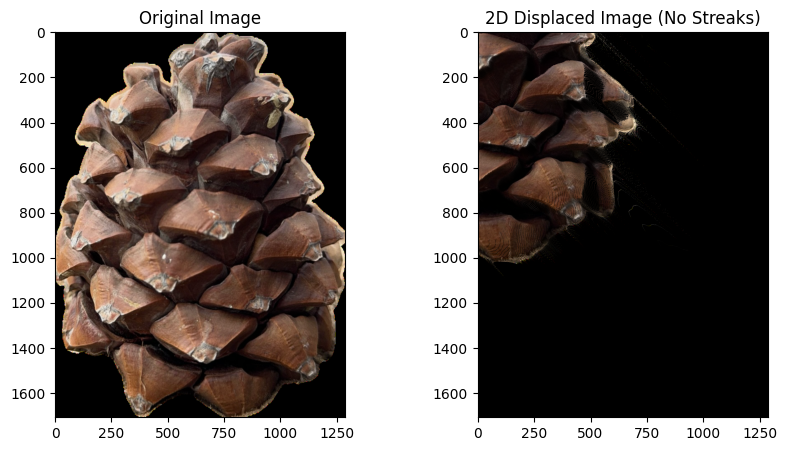

In [104]:
image = cv2.imread("Downloads/Subject.png")
image = cv2.resize(image, (w, h))  # Ensure it matches depth map

# Normalize depth map
depth_map = output2
depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

# Define displacement scales
displacement_x = -750
displacement_y = -750

# Apply square root scaling
scaled_depth = np.sqrt(depth_map)

# Create displacement map
h, w = depth_map.shape
displaced_image = np.zeros_like(image)  # Start with black canvas
valid_mask = np.zeros((h, w), dtype=np.uint8)  # Track moved pixels

for y in range(h):
    for x in range(w):
        shift_x = int(displacement_x * scaled_depth[y, x])
        shift_y = int(displacement_y * scaled_depth[y, x])
        new_x = min(w - 1, max(0, x + shift_x))
        new_y = min(h - 1, max(0, y + shift_y))
        
        # Only copy the pixel, don't interpolate
        displaced_image[new_y, new_x] = image[y, x]
        valid_mask[new_y, new_x] = 1  # Mark as valid pixel

# Fill remaining black pixels (optional)
# If necessary, you can apply inpainting or feathering here to smooth missing areas

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(displaced_image, cv2.COLOR_BGR2RGB))
plt.title("2D Displaced Image (No Streaks)")

plt.show()

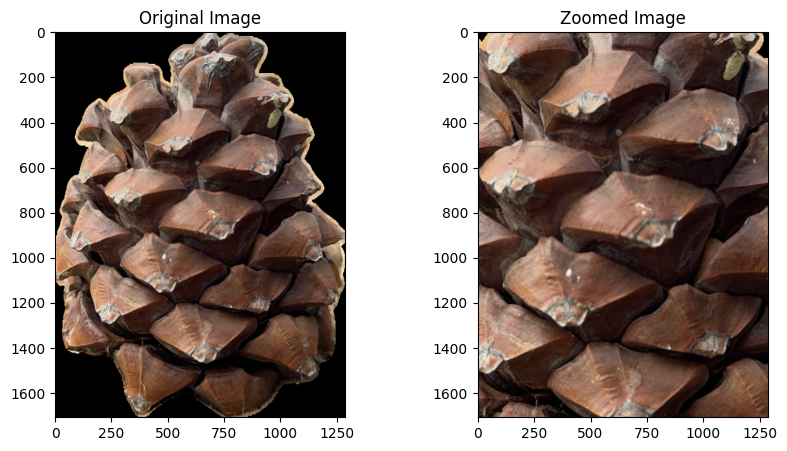

In [101]:
zoom_factor = 1.5 # Try 1.2, 1.5, 2 for stronger zoom

# Get image dimensions
h, w = image.shape[:2]

# Compute new dimensions after zoom
new_w = int(w * zoom_factor)
new_h = int(h * zoom_factor)

# Resize image to simulate zooming (upscale or downscale)
zoomed_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# Crop the zoomed image to maintain the original size
start_x = (new_w - w) // 2
start_y = (new_h - h) // 2
cropped_zoomed_image = zoomed_image[start_y:start_y + h, start_x:start_x + w]

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_zoomed_image, cv2.COLOR_BGR2RGB))
plt.title("Zoomed Image")

plt.show()

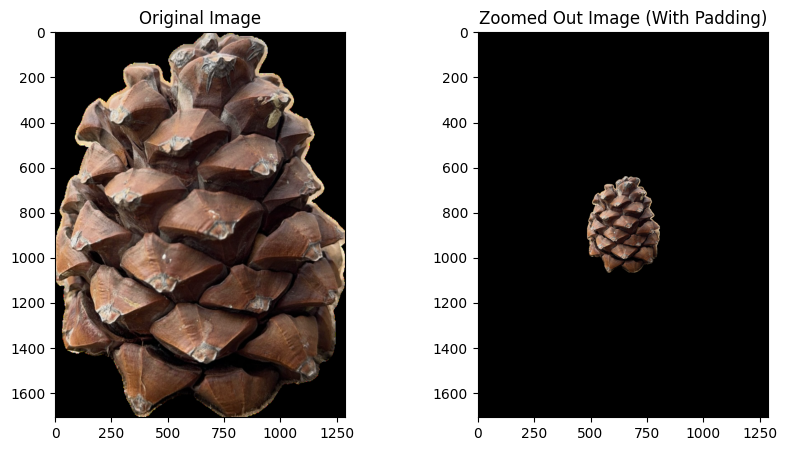

In [100]:
zoom_factor = 0.25  # Zoom out with a factor less than 1

# Get image dimensions
h, w = image.shape[:2]

# Compute new dimensions after zoom (smaller if zooming out)
new_w = int(w * zoom_factor)
new_h = int(h * zoom_factor)

# Resize image (downscale for zoom out)
zoomed_out_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# Calculate padding for maintaining original size
top_padding = (h - new_h) // 2
bottom_padding = h - new_h - top_padding
left_padding = (w - new_w) // 2
right_padding = w - new_w - left_padding

# Apply padding (black background by default)
zoomed_out_with_padding = cv2.copyMakeBorder(
    zoomed_out_image, top_padding, bottom_padding, left_padding, right_padding, 
    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)  # Black padding
)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(zoomed_out_with_padding, cv2.COLOR_BGR2RGB))
plt.title("Zoomed Out Image (With Padding)")

plt.show()

Text(0.5, 1.0, 'Might swerve up bend that corner woah')

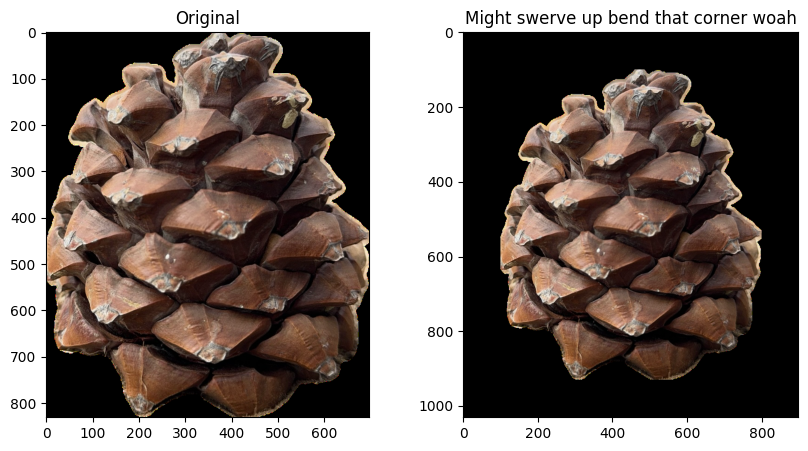

In [94]:
image = cv2.imread("Downloads/Subject.png")
image2 = cv2.copyMakeBorder(
    image, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=(0, 0, 0)
)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread("Downloads/Subject.png"), cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Might swerve up bend that corner woah")